In [11]:
import copy
import torchvision.models as models
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms, autoaugment
from sklearn.utils import resample
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### preparing Data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}')

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.255])

batch_size = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Grayscale(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Grayscale(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.Normalize(mean, std)
    ])
}

data_path = 'D:\Master Project\model\model-1\Corallo-vs-Myxo'
datasets = {x: ImageFolder(root=os.path.join(data_path, x), transform=data_transforms[x]) for x in ['train', 'val']}
print('datasets have been created')

dataloaders = {x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=2, shuffle=False, drop_last=True)
               for x in ['train', 'val']}
print('dataloaders have been created')

class_names = datasets['train'].classes
print(f'there are {len(class_names)} classes, and class names are {class_names}')

class_counts = {x: len(datasets[x]) for x in ['train', 'val']}
print(f'Dataset sizes: {class_counts}')

your device is cuda
datasets have been created
dataloaders have been created
there are 2 classes, and class names are ['Corallococcus', 'Myxococcus']
Dataset sizes: {'train': 415, 'val': 100}


In [3]:
from collections import Counter

class_counts = Counter()

for phase in ['train', 'val']:
    for _, label in dataloaders[phase]:
        class_counts.update(label.tolist())

# show details
for label, count in class_counts.items():
    print(f'Class {label}: {count} instances')

Class 0: 324 instances
Class 1: 156 instances


In [90]:
class CustomAugmentedDataset(Dataset):
    def __init__(self, root_dir, num_samples_per_class, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            num_samples_per_class (int): Desired number of samples per class after augmentation.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataset = ImageFolder(root=root_dir)
        self.num_samples_per_class = num_samples_per_class
        self.transform = transform
        self.augment_transform = transforms.Compose([
            autoaugment.TrivialAugmentWide(num_magnitude_bins=100),
            transforms.ToTensor(),
        ])
        self.class_samples = self._balance_classes()

    def _balance_classes(self):
        from collections import defaultdict
        class_indices = defaultdict(list)
        
        for idx, (_, class_id) in enumerate(self.dataset.samples):
            class_indices[class_id].append(idx)
        
        # Reduce or oversample class indices to match num_samples_per_class
        balanced_indices = []
        for indices in class_indices.values():
            if len(indices) >= self.num_samples_per_class:
                balanced_indices.extend(indices[:self.num_samples_per_class])
            else:
                # Oversample if there are fewer samples than desired
                oversampled_indices = indices * (self.num_samples_per_class // len(indices)) + indices[:self.num_samples_per_class % len(indices)]
                balanced_indices.extend(oversampled_indices)
                
        return balanced_indices

    def __len__(self):
        return len(self.class_samples)

    def __getitem__(self, idx):
        img, label = self.dataset[self.class_samples[idx]]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = self.augment_transform(img)
        return img, label
    
    def __classes__(self):
        return self.dataset.classes

# Example usage:
root_dir = 'D:\Master Project\model\model-1\Corallo-vs-Myxo2\\train'  
num_samples_per_class = 30000

# Define any additional transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

dataset = CustomAugmentedDataset(root_dir=root_dir, num_samples_per_class=num_samples_per_class, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(len(dataset))
print(len(dataloader))


60000
1875


[18487]
<class 'numpy.ndarray'>
['Corallococcus', 'Myxococcus']
0
Corallococcus


C:\Users\Mahdiar\AppData\Local\Temp\ipykernel_4796\3888951998.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image, label = dataset[int(idx)]


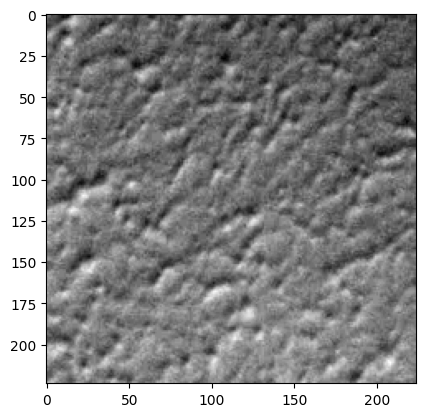

In [208]:
import matplotlib.pyplot as plt
idx = np.random.randint(0, 60000, size=1)

print(idx)
print(type(idx))
image, label = dataset[int(idx)]    
print(dataset.__classes__())
print(label)
print(dataset.__classes__()[label])
image = image.convert('L')
plt.imshow(image, cmap='gray')

plt.show()

50176


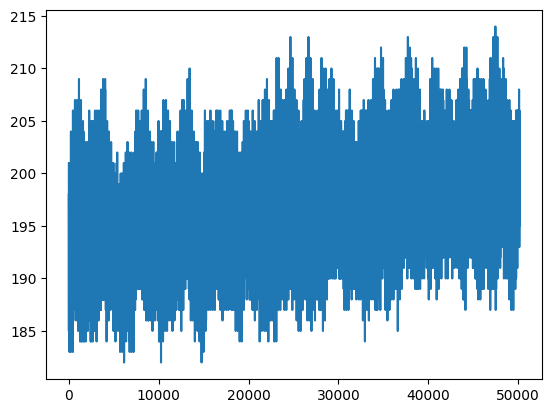

In [209]:
img_signal = np.ravel(image)

print(len(img_signal))
plt.plot(img_signal)
plt.show()

50176
50176
12.044979118688577


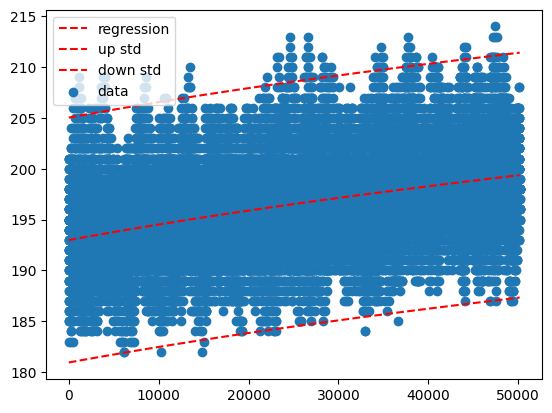

In [212]:
X = np.arange(0, len(img_signal))
y = img_signal
# print(len(X))
# print(len(y))

model = np.poly1d(np.polyfit(X, y, 3))
reg = model(X)
std = np.std(y)
std = std * 3
# print(std)



plt.plot(X, reg, 'r--', label='regression')
plt.plot(X, reg + std, 'r--', label='up std')
plt.plot(X, reg - std, 'r--', label='down std')
plt.scatter(X, y, label='data')
plt.legend()
plt.show()

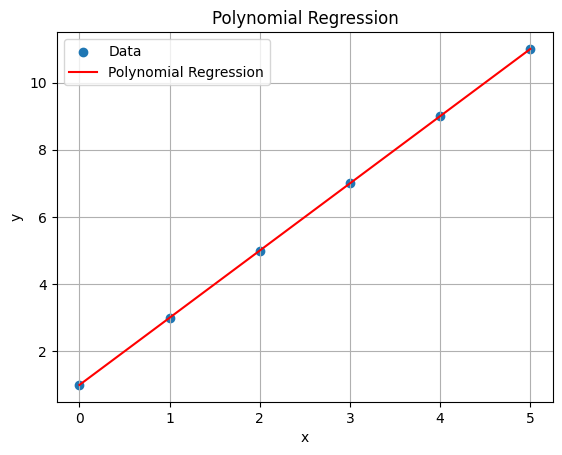

Polynomial equation:
            2
-8.514e-17 x + 2 x + 1


In [190]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([1, 3, 5, 7, 9, 11])

# Perform polynomial regression
degree = 2  # Specify the degree of the polynomial
coefficients = np.polyfit(x, y, degree)

# Create a polynomial function using poly1d
poly_function = np.poly1d(coefficients)

# Generate points for plotting the regression line
x_values = np.linspace(min(x), max(x), 100)
y_values = poly_function(x_values)

# Plot the data points and regression line
plt.scatter(x, y, label='Data')
plt.plot(x_values, y_values, color='red', label='Polynomial Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Regression')
plt.legend()
plt.grid(True)
plt.show()

# Print the polynomial equation
print("Polynomial equation:")
print(poly_function)
